<a href="https://colab.research.google.com/github/MahdiZaman/Spring2019-CAP5610/blob/master/ML_HW3P2_FineTuningwDataAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

********Problem 2********

---



**Download The Data**

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-16 23:05:54--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   237MB/s    in 0.3s    

2019-04-16 23:06:00 (237 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

**Loading the convolutional base**

In [4]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____

**Fine-Tuning the last convolutional layer in Conv. Base and Freezing the other layers**

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv4':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

**Concatenating the convolutional base and densely connected layers**

In [8]:
from keras import layers
from keras import models
from keras import optimizers

#
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))
#

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 4,457,473
Non-trainable params: 17,664,576
_________________________________________________________________


**Using Data Augmentation and defining the training and validation data**

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 25s 251ms/step - loss: 0.6275 - acc: 0.6565 - val_loss: 0.5497 - val_acc: 0.6840
Epoch 2/100
100/100 [==============================] - 18s 176ms/step - loss: 0.5159 - acc: 0.7715 - val_loss: 0.4155 - val_acc: 0.8170
Epoch 3/100
100/100 [==============================] - 18s 176ms/step - loss: 0.4568 - acc: 0.8040 - val_loss: 0.3716 - val_acc: 0.8370
Epoch 4/100
100/100 [==============================] - 18s 176ms/step - loss: 0.4167 - acc: 0.8150 - val_loss: 0.3562 - val_acc: 0.8430
Epoch 5/100
100/100 [==============================] - 19s 186ms/step - loss: 0.3912 - acc: 0.8255 - val_loss: 0.3158 - val_acc: 0.8550
Epoch 6/100
100/100 [==============================] - 19s 190ms/step - loss: 0.3751 - acc: 0.8370 - val_loss: 0.3237 - val_acc: 0.8620
Epoch 7/100
100/100 [==============================] - 18s 180ms/step - loss: 0.3726 - acc: 0.8350 - val_loss: 0.2959 - val_acc: 0.8690


**Displaying Accuracy and Loss in Training and Validation phase**

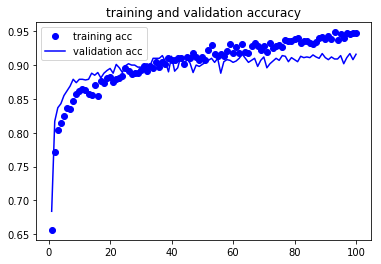

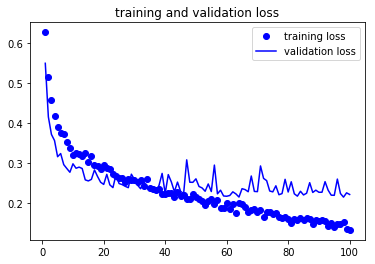

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [12]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

#
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)
#

Validation loss: 0.21231792728067375
Validation accuracy: 0.9199999928474426


**Saving the model in Colab**

In [13]:
model_fname = 'catsdogsclassifier.h5' 
model.save(model_fname)
print("Model saved in Colab")

Model saved in Colab


In [15]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)
print("Model downloaded on Local disk")
print("Problem 2 Ends")

Model downloaded on Local disk
Problem 2 Ends
